In [1]:
from copy import copy
from datetime import datetime  #f'{datetime.today():%m%d_%H%M}'
from IPython.display import display, HTML

import numpy as np
np.set_printoptions(suppress=True)
import pandas as pd
pd.set_option('display.width', 130)    
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 50)    
pd.set_option('precision', 3)
pd.set_option('display.float_format', lambda x: '%0.4f' % x)
import random

In [2]:
import matplotlib.pyplot as plt
#import warnings
#warnings.filterwarnings("ignore", module = "matplotlib\..*" )
import logging
logging.getLogger('matplotlib').setLevel(logging.ERROR)


import seaborn as sns
sns.set(font_scale=1.3, style='whitegrid')

In [3]:
from sklearn import metrics

In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers

#from tensorflow.keras import backend as K
#physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
!ln -s -f ../utils/utils.py utils.py
import utils
#import importlib
#importlib.reload(utils)

# Data

Since eventuially I am aiming at production code, let us 

* read our data from scratch
* remove useless columns 
* remove settings
* define RUL = Remaining Useful Lifetime
    
as discussed earlier in Part1: Exploratory-Data-Analysis. 

## Read the data

##### Train

In [6]:
data = pd.read_csv("../../data/train_FD001.txt", sep=r"\s+", index_col=False, header=None)
print('Turbofan train data')
print(data.shape)
data.columns = ["unit", "cycle"] + ["setting"+str(i) for i in (1,2,3)] + ["s"+str(i) for i in range(1,22)]
units = data["unit"].unique(); 
data.head()

Turbofan train data
(20631, 26)


,unit,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0000,518.6700,641.8200,1589.7000,1400.6000,14.6200,21.6100,554.3600,2388.0600,9046.1900,1.3000,47.4700,521.6600,2388.0200,8138.6200,8.4195,0.0300,392,2388,100.0000,39.0600,23.4190
1,1,2,0.0019,-0.0003,100.0000,518.6700,642.1500,1591.8200,1403.1400,14.6200,21.6100,553.7500,2388.0400,9044.0700,1.3000,47.4900,522.2800,2388.0700,8131.4900,8.4318,0.0300,392,2388,100.0000,39.0000,23.4236
2,1,3,-0.0043,0.0003,100.0000,518.6700,642.3500,1587.9900,1404.2000,14.6200,21.6100,554.2600,2388.0800,9052.9400,1.3000,47.2700,522.4200,2388.0300,8133.2300,8.4178,0.0300,390,2388,100.0000,38.9500,23.3442
3,1,4,0.0007,0.0000,100.0000,518.6700,642.3500,1582.7900,1401.8700,14.6200,21.6100,554.4500,2388.1100,9049.4800,1.3000,47.1300,522.8600,2388.0800,8133.8300,8.3682,0.0300,392,2388,100.0000,38.8800,23.3739
4,1,5,-0.0019,-0.0002,100.0000,518.6700,642.3700,1582.8500,1406.2200,14.6200,21.6100,554.0000,2388.0600,9055.1500,1.3000,47.2800,522.1900,2388.0400,8133.8000,8.4294,0.0300,393,2388,100.0000,38.9000,23.4044


In [7]:
n_sensors = len(utils.useful_sensors)
data = data[[c for c in data.columns if c not in (utils.useless_sensors+utils.factor_sensors+utils.settings)]]
#data = data[utils.numeric_sensors]

##### Test

In [8]:
# print('Turbofan test data')
# test = pd.read_csv("../input/train_FD001.txt", sep=r"\s+", index_col=False, header=None)
# print('Turbofan train data')
# print(data.shape)
# data.columns = ["unit", "cycle"] + ["setting"+str(i) for i in (1,2,3)] + ["s"+str(i) for i in range(1,22)]
# units = data["unit"].unique(); 
# data.head()

## Define RUL

In [9]:
max_cycle = data["cycle"].groupby(data['unit']).transform('max')
data["RUL"] = max_cycle - data["cycle"]

In [10]:
#data["cycle"].groupby(data['unit']).transform(len).min()  # 128

<AxesSubplot:>

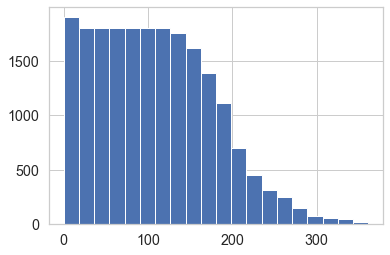

In [11]:
data["RUL"].hist(bins=20)

## Scaling sensor measurements

Nearly each Machine Learning model benefits from appropriate data scaling/normalization. This es especially true for Neural Networks, since it helps to avoid diverging gradient problem. But how the scaling should be done? 

### Question to discuss: what about MinMaxScaler?

In several approaches (for example, at [Hands-On-Artificial-Intelligence-for-IoT](https://github.com/PacktPublishing/Hands-On-Artificial-Intelligence-for-IoT) and also at [umbertogriffo](https://github.com/umbertogriffo/Predictive-Maintenance-using-LSTM)) to the Turbofan problem the scaling is done by using the MinMax scaler. But is this approach appropriate here? 

Let us think for a moment. As we saw in the exploratory analysis, each unit starts from a slightly different sensor measurement. And this measurement is intrinsically noisy - even for RUL > 100 the measured values vary a bit.

Close to the end of the unit's life, the measurement deviates significantly from its normal level. The deviation can be either positive or negative, growing rapidly close to the unit's failure. The final value of measurement significantly varies and essentially carries no useful information. 

### My choice: Scale sensor measurements by removing the baseline

Let us to capture the concept of _baseline_ - measurements that are _normal_  for each sensor. 
Then prozent deviations from this baseline will be an indicator of the unit RUL.

In [12]:
#data['RUL'].quantile(0.95)
#assert 0<0.05<1

In [13]:
def get_baseline(data, max_cycle=30, top_RUL=0.05):
    if 'cycle' in data.columns:
        # assume that each unit in training data has 30 
        return data.loc[data.cycle<max_cycle, utils.useful_sensors].mean()
    elif 'RUL' in data.columns:
        assert 0 < top_RUL <= 0.2, 'top_RUL should be at most 0.2'
        # use top-5% RULs as baselines
        threshold_RUL = data['RUL'].quantile(1-top_RUL)
        return data.loc[data.RUL>threshold_RUL, utils.useful_sensors].mean()
    else:
        raise KeyError('cannot calculate baseline: neither "Cycle" nor "RUL" column is data')
        return None
    
print('Baseline (here only for demonstration, for training it will be recalculated only on training data)')
baseline = get_baseline(data)
#baseline
display(HTML(baseline.to_frame(name='baseline').T.round(1).to_html()))

Baseline (here only for demonstration, for training it will be recalculated only on training data)


,s2,s3,s4,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21
baseline,642.4000,1586.9000,1402.8000,553.9000,2388.1000,9056.1000,47.4000,521.9000,2388.1000,8137.4000,8.4000,392.3000,38.9000,23.4000


In [14]:
def scale_sensors(data, baseline):
    return (data[utils.useful_sensors].div(baseline, axis=1)-1)*100 # to_percent
print('Scaled sensor measurements (here only for demonstration, for training it will be recalculated with training baseline)')
bdata = scale_sensors(data, baseline)
bdata.tail()

Scaled sensor measurements (here only for demonstration, for training it will be recalculated with training baseline)


,s2,s3,s4,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21
20626,0.1723,0.6988,1.8395,-0.4546,0.0055,0.1042,1.5089,-0.4627,0.0085,0.0027,0.9179,1.2056,-1.1351,-1.6523
20627,0.1801,1.1096,2.1924,-0.5575,0.0071,0.0997,1.4455,-0.4262,0.0068,-0.0109,1.1353,0.6958,-1.6232,-0.8565
20628,0.1614,0.9811,1.8074,-0.5431,0.0076,0.1084,1.5511,-0.3630,0.0077,0.0450,1.7376,1.4606,-1.2635,-1.8244
20629,0.1318,1.1575,1.6898,-0.5900,0.0080,0.1947,2.1846,-0.4282,0.0073,0.0234,1.4323,0.6958,-1.6488,-1.2649
20630,0.2283,0.8500,2.0897,-0.5702,0.0084,0.0596,1.7834,-0.4991,0.0085,-0.0007,1.0130,0.9507,-1.4434,-1.3154


The actual computation will be performed later, using only training subset for determining the baseline.

##### Keep unit and RUL as variables

In [15]:
#bdata.sort_values(by=['unit', 'RUL'], ascending=[True, False], inplace=True)
assert all(data.sort_values(by=['unit', 'RUL'], ascending=[True, False])== data)

In [16]:
bdata_unit = data['unit'].copy()
bdata_RUL = data['RUL'].copy()
#bdata_RUL.head()
#bdata_RUL.head()

# Business insight: regression for logRUL

We want to predict the RUL, which is the real value, therefore this is a regression problem. 

From the business point of view, we want to pay a closer attention to lower RUL values. It does not matter, if the unit will still live 90 or 95 days, correct? But there is a large difference between living 1 and 6 days.

To transform this business requirements to mathematical terms, I `log-transform` the RUL. By this term I actually mean the following transfomation 

$$ logRUL = ln(1. + RUL) $$

The value of 1 is added before the log-transform, so that RUL=0 will be transformed to logRUL=0.

In [17]:
bdata_logRUL = bdata_RUL.apply(np.log1p) # log-transform RemainingUsefulTime

# Data split:  Train, validation and test

Since our units are independent, the split is made by unit number: 

* randomly selected 10 units for test
* randomly selected (from the rest) 10 for validation
* the rest (80 units) for train

##### Split units

Let us keep all units in one dictionaty - `units_tvt`

In [18]:
unique_units = set(bdata_unit.unique().tolist())
units_tvt = dict()
units_tvt['vali'] = random.sample(list(unique_units), 20)
print('Units for validation', units_tvt['vali'])
units_tvt['holdout'] = random.sample(list(unique_units - set(units_tvt['vali'])), 20)
print('Units for holdout', units_tvt['holdout'])
units_tvt['train'] = unique_units - set(units_tvt['vali']) - set(units_tvt['holdout'])

Units for validation [96, 71, 43, 54, 20, 25, 85, 31, 80, 9, 63, 62, 69, 40, 21, 86, 98, 27, 91, 46]
Units for holdout [44, 2, 51, 83, 7, 15, 60, 30, 53, 3, 4, 29, 95, 90, 97, 55, 87, 73, 81, 57]


##### Baseline on train units only

In [19]:
print('Baseline')
baseline = get_baseline(data[data.unit.isin(units_tvt['train'])])
display(HTML(baseline.to_frame(name='baseline').T.to_html()))

Baseline


,s2,s3,s4,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21
baseline,642.4035,1587.1706,1403.2385,553.9191,2388.0636,9055.6426,47.3668,521.8707,2388.0609,8136.8595,8.4191,392.3241,38.9244,23.3557


In [20]:
print('Scaled sensor measurements')
bdata = scale_sensors(data, baseline)
bdata.head()

Scaled sensor measurements


,s2,s3,s4,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21
0,-0.0908,0.1594,-0.1880,0.0796,-0.0002,-0.1044,0.2178,-0.0404,-0.0017,0.0216,0.0050,-0.0826,0.3483,0.2709
1,-0.0395,0.2929,-0.0070,-0.0305,-0.0010,-0.1278,0.2600,0.0784,0.0004,-0.0660,0.1511,-0.0826,0.1941,0.2905
2,-0.0083,0.0516,0.0685,0.0615,0.0007,-0.0298,-0.2044,0.1053,-0.0013,-0.0446,-0.0152,-0.5924,0.0657,-0.0494
3,-0.0083,-0.2760,-0.0975,0.0958,0.0019,-0.0681,-0.5000,0.1896,0.0008,-0.0372,-0.6043,-0.0826,-0.1141,0.0778
4,-0.0052,-0.2722,0.2125,0.0146,-0.0002,-0.0054,-0.1833,0.0612,-0.0009,-0.0376,0.1226,0.1723,-0.0628,0.2083


## Formulate the business problem: 
#### how many days of business data for each unit do you have before you need prediction

* If you use your equipment long-term it can be many data points for each unit, let us say 64 or more (in this case 64 or more days)
* If you test used equipment, you can have only few days, let us say 32 (in this case 32 days)

Set the WINDOW_SIZE variable accordingly

In [21]:
WINDOW_SIZE = 32

### Generating training samples
For each unit I sample sequences of WINDOW_SIZE and see what is the RUL for the last day.

### Questions to discuss:
* How would you approach sampling? 
* What business consideratons would you consider?
* How would you translate this to mathematical language?
* Which approach do you see in my code?

In [22]:
def gen_random_sequences_various_units(unit_se, df, target_se, seq_length=16, batch_size=32, 
                                selected_units=None, verbose=False):
    """
    Generates batches to use for model training or validation
    Inputs:
        unit_se: pd.Series -  unit numbers extracted from train data
        df: pd.DataFrame - data frame with scaled data
        target_se: pd.Series - logRUL extracted from the train data
        seq_length: int - sequence length for the model input
        batch_size: int - size of the batch size to generate
        selected_units: list - list of units to use, it can be train_units, validation_units 
    
    Output:
        xx: (batch_size, seq_length, number_of_columns_in_df) - batch of features
        yy: (batch_size,) - ground truth for RUL
    """
    assert len(df.shape) == 2
    probs = np.exp(-0.5*target_se[unit_se.isin(selected_units)].values); probs = probs/sum(probs)
    tmp = np.hstack([unit_se[unit_se.isin(selected_units)].values.reshape(-1,1),
                     target_se[unit_se.isin(selected_units)].values.reshape(-1,1),
                     df[unit_se.isin(selected_units)].values])
    #display(tmp[:5,:])
    
    while True:
        xx = list()
        yy = list()
        while len(yy)<batch_size:
            stop = np.random.choice(range(len(tmp)), 1, p=probs)[0]
            start = stop - seq_length
            if tmp[start,0] == tmp[stop,0]: # all data belong to one unit
                xx.append(tmp[start:stop,2:])
                yy.append(tmp[stop,1])
                if verbose:
                    print('unit {:.0f}, start {:d}, stop {:d}, RUL {:.0f}'.format(
                           tmp[stop,0], start, stop, np.expm1(tmp[stop,1])) )
            
        yield np.stack(xx), np.stack(yy)

In [23]:
data_gen = gen_random_sequences_various_units(unit_se=bdata_unit, df=bdata, target_se=bdata_logRUL, 
                                       seq_length=WINDOW_SIZE, selected_units=units_tvt['train'],
                                       batch_size=8, verbose=True)

In [24]:
print('Check that data generator is working by generating several samples')
xx, yy = next(data_gen)
print('shape of xx', xx.shape)
print('shape of yy', yy.shape, 'yy', yy)

Check that data generator is working by generating several samples
unit 100, start 12049, stop 12081, RUL 46
unit 78, start 9823, stop 9855, RUL 23
unit 22, start 2753, stop 2785, RUL 28
unit 32, start 3620, stop 3652, RUL 31
unit 92, start 11043, stop 11075, RUL 254
unit 58, start 6896, stop 6928, RUL 44
unit 42, start 5176, stop 5208, RUL 113
unit 41, start 5089, stop 5121, RUL 4
shape of xx (8, 32, 14)
shape of yy (8,) yy [3.8501476  3.17805383 3.36729583 3.4657359  5.54126355 3.80666249
 4.73619845 1.60943791]


# Building recursive Neural Network with GRU units

### Model formulation

### Define architecture

Let us formulate the model:
    
 * as input it expect sequencies of length WINDOW_SIZE with 14 features
 * the first layer is GRU layer with 2-3 units to ensure dimensionality reduction of the noisy sensors
 * following is another GRU with more units to build nonlinear features
 * the final layer is Dense with 1  output unit, which correesponds to RUL
    

In [25]:
def make_gru_seq_model(seq_length, n_features, dimred=2, gru_units=8):
    input_sensors = layers.Input(shape=(seq_length, n_features), 
                                 name='input_sensors')
    x = layers.Masking(mask_value=0.0)(input_sensors)
    x = layers.GRU(units=dimred, return_sequences=True, 
                   stateful=False, name='dimred')(x)
    x = layers.GRU(units=gru_units, return_sequences=False, stateful=False, name='gru1')(x)
    RUL = layers.Dense(1, activation=None, name='RUL')(x)
    gru1 = models.Model(inputs=input_sensors, outputs=RUL)
    return gru1

In [26]:
WINDOW_SIZE=32
dimred=2
gru_units=6
gru1= make_gru_seq_model(seq_length=WINDOW_SIZE,  n_features=n_sensors,
                              dimred=dimred, gru_units=gru_units)
display(gru1.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_sensors (InputLayer)  [(None, 32, 14)]          0         
                                                                 
 masking (Masking)           (None, 32, 14)            0         
                                                                 
 dimred (GRU)                (None, 32, 2)             108       
                                                                 
 gru1 (GRU)                  (None, 6)                 180       
                                                                 
 RUL (Dense)                 (None, 1)                 7         
                                                                 
Total params: 295
Trainable params: 295
Non-trainable params: 0
_________________________________________________________________


None

In [27]:
gru1.compile(optimizer=optimizers.Adam(1e-3), 
                 loss='mean_squared_error', metrics=['mae'])

### Fit

During fit I will 

* monitor the training process with TensorBoard callback 
* use EarlyStoppping callback to prevent overfitting
* save the best model with ModelCheckpoint callback

In [28]:
BATCH_SIZE = 64
monitor = 'val_mae'; mode='min'

In [30]:
log_dir = f'../../logs_{datetime.today():%m%d}/window{WINDOW_SIZE:d}_dimred{dimred:d}_gru{gru_units:d}_monitor:{monitor:s}_{datetime.today():%H%M}'
print('Logging directory', log_dir)
tensorboard_cb = callbacks.TensorBoard(log_dir=log_dir, histogram_freq=50, write_graph=False,
                                      write_grads=False, write_images=True)
#
reduce_lr = callbacks.ReduceLROnPlateau(monitor=monitor, mode=mode, min_delta=0.001, factor=0.5, patience=10)
#
early_cb = callbacks.EarlyStopping(monitor=monitor, mode=mode, min_delta=0.001, patience=15, 
                                   verbose=0, restore_best_weights=True)
#
model_directory = f'ipynb_models/window{WINDOW_SIZE:d}_dimred{dimred:d}_gru{gru_units:d}_model'
best_cb = callbacks.ModelCheckpoint(filepath=model_directory, monitor=monitor, mode=mode, save_best_only=True)

Logging directory ../../logs_0202/window32_dimred2_gru6_monitor:val_mae_1412


In [31]:
data_gen = gen_random_sequences_various_units(unit_se=bdata_unit, df=bdata, target_se=bdata_logRUL, 
                                              seq_length=WINDOW_SIZE, 
                                              selected_units=units_tvt['train'], batch_size=BATCH_SIZE)

In [32]:
vali_gen = gen_random_sequences_various_units(unit_se=bdata_unit, df=bdata, target_se=bdata_logRUL, 
                                              seq_length=WINDOW_SIZE, 
                                              selected_units=units_tvt['vali'], batch_size=BATCH_SIZE)

In [33]:
hist = gru1.fit(data_gen, epochs=100, steps_per_epoch=50, 
                validation_data=vali_gen, validation_steps=16,
                callbacks=[tensorboard_cb, early_cb, reduce_lr], 
                verbose=1)

Epoch 1/100
50/50 [==============================] - 18s 160ms/step - loss: 11.3219 - mae: 3.0438 - val_loss: 9.3595 - val_mae: 2.6970 - lr: 0.0010
Epoch 2/100
50/50 [==============================] - 5s 93ms/step - loss: 6.5608 - mae: 2.1967 - val_loss: 4.4734 - val_mae: 1.7833 - lr: 0.0010
Epoch 3/100
50/50 [==============================] - 5s 92ms/step - loss: 3.1715 - mae: 1.4820 - val_loss: 2.6153 - val_mae: 1.3268 - lr: 0.0010
Epoch 4/100
50/50 [==============================] - 5s 93ms/step - loss: 2.3289 - mae: 1.2441 - val_loss: 2.1749 - val_mae: 1.1947 - lr: 0.0010
Epoch 5/100
50/50 [==============================] - 5s 94ms/step - loss: 2.1474 - mae: 1.1872 - val_loss: 2.0325 - val_mae: 1.1637 - lr: 0.0010
Epoch 6/100
50/50 [==============================] - 4s 91ms/step - loss: 2.0252 - mae: 1.1557 - val_loss: 2.0550 - val_mae: 1.1589 - lr: 0.0010
Epoch 7/100
50/50 [==============================] - 5s 92ms/step - loss: 1.9004 - mae: 1.1194 - val_loss: 1.9152 - val_mae: 1.

In [34]:
gru1.save(model_directory)
#list(hist.history.keys())

2022-02-02 14:21:25 WARNING  absl         _initialize_nodes_and_concrete_functions line_263 Found untraced functions such as gru_cell_layer_call_fn, gru_cell_layer_call_and_return_conditional_losses, gru_cell_1_layer_call_fn, gru_cell_1_layer_call_and_return_conditional_losses, gru_cell_layer_call_fn while saving (showing 5 of 10). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ipynb_models/window32_dimred2_gru6_model/assets


2022-02-02 14:21:34 INFO     tensorflow   copy_assets_to_destination_dir line_783 Assets written to: ipynb_models/window32_dimred2_gru6_model/assets
2022-02-02 14:21:38 WARNING  absl         generate_keras_metadata line_133 <keras.layers.recurrent.GRUCell object at 0x7fa335f9f5e0> has the same name 'GRUCell' as a built-in Keras object. Consider renaming <class 'keras.layers.recurrent.GRUCell'> to avoid naming conflicts when loading with `tf.keras.models.load_model`. If renaming is not possible, pass the object in the `custom_objects` parameter of the load function.
2022-02-02 14:21:38 WARNING  absl         generate_keras_metadata line_133 <keras.layers.recurrent.GRUCell object at 0x7fa335ee6d60> has the same name 'GRUCell' as a built-in Keras object. Consider renaming <class 'keras.layers.recurrent.GRUCell'> to avoid naming conflicts when loading with `tf.keras.models.load_model`. If renaming is not possible, pass the object in the `custom_objects` parameter of the load function.


In [35]:
performance_se = pd.Series(index=hist.history.keys(), dtype=float)
for key in hist.history.keys():
    performance_se.loc[key] = hist.history[key][-1]
    print(key, hist.history[key][-1])

loss 0.12265577912330627
mae 0.2761695981025696
val_loss 0.12101147323846817
val_mae 0.27306315302848816
lr 0.001


In [36]:
HTML(performance_se.to_frame(name='train and validation metrics').to_html())    

,train and validation metrics
loss,0.1227
mae,0.2762
val_loss,0.1210
val_mae,0.2731
lr,0.0010


### Tensorboard Snippets

In [37]:
#%reload_ext tensorboard

In [38]:
#%tensorboard --logdir {log_dir}

## Read the saved model

In [39]:
print('Load the best model', model_directory)
from tensorflow import keras
trained_model = keras.models.load_model(model_directory)


Load the best model ipynb_models/window32_dimred2_gru6_model


In [40]:
#print(dir(trained_model))

In [41]:
trained_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_sensors (InputLayer)  [(None, 32, 14)]          0         
                                                                 
 masking (Masking)           (None, 32, 14)            0         
                                                                 
 dimred (GRU)                (None, 32, 2)             108       
                                                                 
 gru1 (GRU)                  (None, 6)                 180       
                                                                 
 RUL (Dense)                 (None, 1)                 7         
                                                                 
Total params: 295
Trainable params: 295
Non-trainable params: 0
_________________________________________________________________


In [42]:
trained_model.input_shape

(None, 32, 14)

### Predict and evaluate performance on holdout set

In [43]:
holdout_gen = gen_random_sequences_various_units(unit_se=bdata_unit, df=bdata, target_se=bdata_logRUL, 
                                              seq_length=WINDOW_SIZE, 
                                              selected_units=units_tvt['holdout'], batch_size=2048)
x, ground_truth_y  = next(holdout_gen)
predi_y = trained_model.predict(x)

In [44]:
mae_holdout = metrics.mean_absolute_error(y_pred = predi_y.flatten(), y_true=ground_truth_y.flatten())
r2_holdout = metrics.r2_score(y_pred = predi_y.flatten(), y_true=ground_truth_y.flatten())
print('R2 holdout {:.3f}'.format(r2_holdout))
performance_se.loc['mae_holdout'] = mae_holdout
performance_se.loc['r2_holdout'] = r2_holdout

R2 holdout 0.945


### Visualize predictions for holdout data

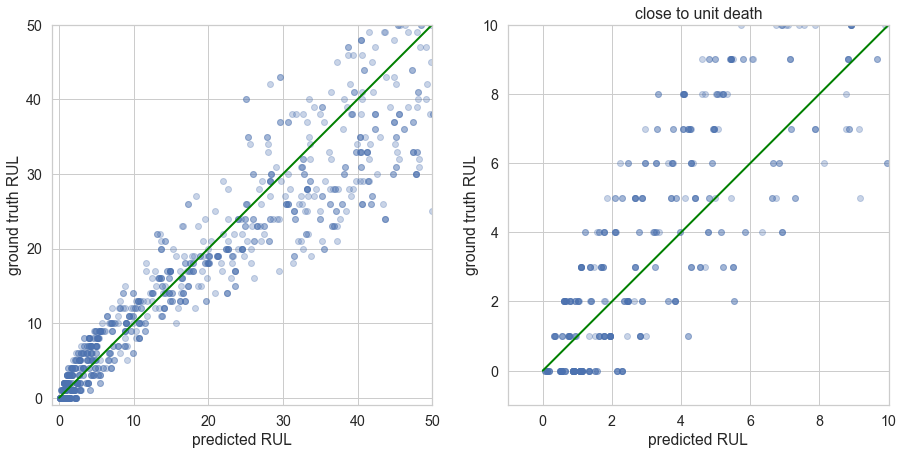

In [45]:
fig = utils.scatter_groundtruth_vs_predicted(absciss=predi_y.flatten(), 
                                             ordinate=ground_truth_y.flatten())

## Predict on the given Turbofan test data

### Read data

In [46]:
test = pd.read_csv("../../data/test_FD001.txt", sep=r"\s+", index_col=False, header=None)
print('Turbofan test data')
print(test.shape)
test.columns = ["unit", "cycle"] + ["setting"+str(i) for i in (1,2,3)] + ["s"+str(i) for i in range(1,22)]
#units = data["unit"].unique(); 
print(test.shape)
test.head()

Turbofan test data
(13096, 26)
(13096, 26)


,unit,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,0.0023,0.0003,100.0000,518.6700,643.0200,1585.2900,1398.2100,14.6200,21.6100,553.9000,2388.0400,9050.1700,1.3000,47.2000,521.7200,2388.0300,8125.5500,8.4052,0.0300,392,2388,100.0000,38.8600,23.3735
1,1,2,-0.0027,-0.0003,100.0000,518.6700,641.7100,1588.4500,1395.4200,14.6200,21.6100,554.8500,2388.0100,9054.4200,1.3000,47.5000,522.1600,2388.0600,8139.6200,8.3803,0.0300,393,2388,100.0000,39.0200,23.3916
2,1,3,0.0003,0.0001,100.0000,518.6700,642.4600,1586.9400,1401.3400,14.6200,21.6100,554.1100,2388.0500,9056.9600,1.3000,47.5000,521.9700,2388.0300,8130.1000,8.4441,0.0300,393,2388,100.0000,39.0800,23.4166
3,1,4,0.0042,0.0000,100.0000,518.6700,642.4400,1584.1200,1406.4200,14.6200,21.6100,554.0700,2388.0300,9045.2900,1.3000,47.2800,521.3800,2388.0500,8132.9000,8.3917,0.0300,391,2388,100.0000,39.0000,23.3737
4,1,5,0.0014,0.0000,100.0000,518.6700,642.5100,1587.1900,1401.9200,14.6200,21.6100,554.1600,2388.0100,9044.5500,1.3000,47.3100,522.1500,2388.0300,8129.5400,8.4031,0.0300,390,2388,100.0000,38.9900,23.4130


How many points (=days) are available for each unit?


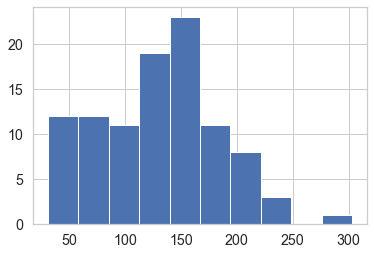

In [47]:
print('How many points (=days) are available for each unit?')
days_per_unit = test.groupby('unit')['cycle'].apply(max)
days_per_unit.hist(bins=10, label='number of units');

In [48]:
test_RUL = pd.read_csv("../../data/RUL_FD001.txt", sep=r"\s+", index_col=False, header=None)
test_RUL.reset_index(inplace=True)
test_RUL.columns=['unit', 'RUL']
test_RUL['unit'] += 1
print('Turbofan RUL for test data')
print(test_RUL.shape)
test_RUL.head()

Turbofan RUL for test data
(100, 2)


,unit,RUL
0,1,112
1,2,98
2,3,69
3,4,82
4,5,91


### Scale sensors

In [49]:
print('Scaled sensor measurements. Baseline for each sensor is known from training data!')
btest = scale_sensors(test, baseline)
btest

Scaled sensor measurements. Baseline for each sensor is known from training data!


,s2,s3,s4,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21
0,0.0960,-0.1185,-0.3584,-0.0034,-0.0010,-0.0604,-0.3522,-0.0289,-0.0013,-0.1390,-0.1648,-0.0826,-0.1655,0.0760
1,-0.1080,0.0806,-0.5572,0.1681,-0.0022,-0.0135,0.2811,0.0554,-0.0000,0.0339,-0.4606,0.1723,0.2455,0.1535
2,0.0088,-0.0145,-0.1353,0.0345,-0.0006,0.0145,0.2811,0.0190,-0.0013,-0.0831,0.2972,0.1723,0.3997,0.2606
3,0.0057,-0.1922,0.2267,0.0272,-0.0014,-0.1143,-0.1833,-0.0940,-0.0005,-0.0487,-0.3252,-0.3375,0.1941,0.0769
4,0.0166,0.0012,-0.0940,0.0435,-0.0022,-0.1225,-0.1200,0.0535,-0.0013,-0.0900,-0.1898,-0.5924,0.1685,0.2452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,0.1302,0.7737,0.8945,-0.0919,-0.0018,0.9577,0.6823,-0.2262,-0.0026,0.9392,0.6227,0.4272,-0.7050,-0.6779
13092,0.1271,0.5368,1.3406,-0.1262,-0.0006,0.9391,0.4922,-0.1573,0.0012,0.9093,0.3816,0.6821,-0.9106,-0.3367
13093,0.1613,0.3767,0.2552,-0.1587,0.0019,1.0067,0.4289,-0.1324,-0.0009,0.9879,0.4493,0.6821,-0.7821,-0.6450
13094,0.1333,0.4927,1.1489,-0.0991,0.0003,1.0293,0.5134,-0.1036,0.0008,1.0277,0.6179,0.6821,-0.6793,-0.3675


In [50]:
from keras.preprocessing.sequence import pad_sequences

def generate_padding_input(WINDOW_SIZE):
    def padding_input(sequences):
        #sequence1 = np.expand_dims(sequence,0)
        return pad_sequences(sequences, maxlen=WINDOW_SIZE, dtype=float, 
                            padding='pre', truncating='pre', value=0.0)
    return padding_input    
    
padding = generate_padding_input(WINDOW_SIZE)    

In [51]:
#list_of_sequences = [btest[test['unit']==unit].values for unit in test_RUL['unit'].to_list()]
#len(list_of_sequences)

In [52]:
btest_WINDOW_SIZE = padding([btest[test['unit']==unit].values for unit in test_RUL['unit'].to_list()])
print(btest_WINDOW_SIZE.shape)

(100, 32, 14)


In [53]:
# --- is replaces with keras.preprocessing.sequence.pad_sequence
# btest_WINDOW_SIZE = np.array([btest[test_unit==unit].values[-WINDOW_SIZE:] 
#                            for unit in test_RUL['unit'].values 
#                            if len(btest[test_unit==unit]) >= WINDOW_SIZE])

# print(btest_WINDOW_SIZE.shape)

In [54]:
#vali_gen = gen_random_sequences_various_units(unit_se=bdata_unit, df=bdata, target_se=bdata_logRUL, 
#                                              seq_length=WINDOW_SIZE, 
#                                              selected_units=units_tvt['vali'], batch_size=64)

### Predict

In [55]:
predi_test_y = trained_model.predict(btest_WINDOW_SIZE)
ground_truth_test_y = test_RUL['RUL'].apply(np.log1p).values

In [56]:
mae_test = metrics.mean_absolute_error(y_pred = predi_test_y.flatten(), y_true=ground_truth_test_y.flatten())
print('MAE test {:.3f}'.format(mae_test))
r2_test = metrics.r2_score(y_pred = predi_test_y.flatten(), y_true=ground_truth_test_y.flatten())
print('R2 test {:.3f}'.format(r2_test))

MAE test 0.207
R2 test 0.890


In [57]:
performance_se.loc['mae_Trubofan_test'] = mae_test
performance_se.loc['r2_Trubofan_test'] = r2_test

### Visualize predictions

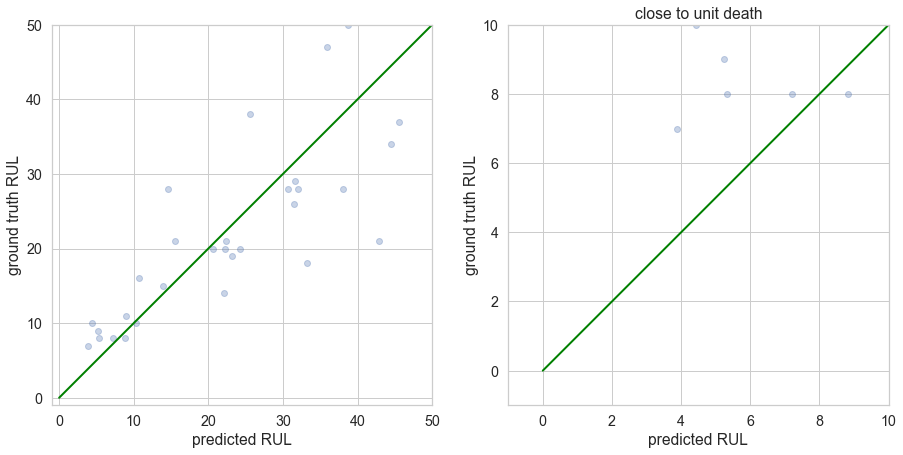

In [58]:
# xy_lim=(-1,100), xy_low_lim=(-1,20)
fig = utils.scatter_groundtruth_vs_predicted(absciss=predi_test_y.flatten(), 
                                             ordinate=ground_truth_test_y.flatten())

In [59]:
HTML(performance_se.to_frame(name='train and validation metrics').to_html())    

,train and validation metrics
loss,0.1227
mae,0.2762
val_loss,0.1210
val_mae,0.2731
lr,0.0010
mae_holdout,0.2652
r2_holdout,0.9453
mae_Trubofan_test,0.2069
r2_Trubofan_test,0.8899


## Questions to discuss?

* What would be your next step in developing/improving this model?
* What major concern about these results do you see from the business-user viewpoint?
* How would you as Senior Machine Learning Engineer address these concerns?

## Moving to production code

* check that train and test data are consistent
* after training not only the model should be saved, but also the baseline
* since train/validation results are close, train on the whole dataset without concern of overfitting